# We will build RNN for Stocks/Crypto price tracking

In [349]:
import json
import os

import torch
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [350]:
import yfinance as yf

In [351]:
hdfc = yf.download(tickers=["HDFCBANK.NS"], start="2022-01-02", interval='1d')
hdfc

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS
Date,,,,,
2022-01-03,1465.145264,1468.375087,1427.399420,1431.738020,4534592
2022-01-04,1473.726074,1477.920031,1453.720307,1465.482687,4428676
2022-01-05,1508.724121,1515.617698,1473.292219,1481.680250,7166319
2022-01-06,1484.524292,1498.986292,1475.172246,1487.657725,4814465
2022-01-07,1494.937012,1510.555925,1480.812435,1488.621891,5589692
...,...,...,...,...,...
2025-05-21,1926.800049,1946.900024,1921.099976,1927.000000,7566020
2025-05-22,1919.900024,1924.199951,1905.199951,1915.199951,10653335


In [352]:
df = hdfc['Close']
df['date'] = df.index
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.reset_index(drop=True, inplace=True)
df.columns = ['Close', 'date']
df['Close'] = df['Close'].round(2)
df['y'] = df['Close'].shift(-1)

df = df[['date', 'Close', 'y']]

df

,date,Close,y
0,2022-01-03,1465.15,1473.73
1,2022-01-04,1473.73,1508.72
2,2022-01-05,1508.72,1484.52
3,2022-01-06,1484.52,1494.94
4,2022-01-07,1494.94,1503.23
...,...,...,...
833,2025-05-21,1926.80,1919.90
834,2025-05-22,1919.90,1933.60
835,2025-05-23,1933.60,1940.20
836,2025-05-26,1940.20,1926.30


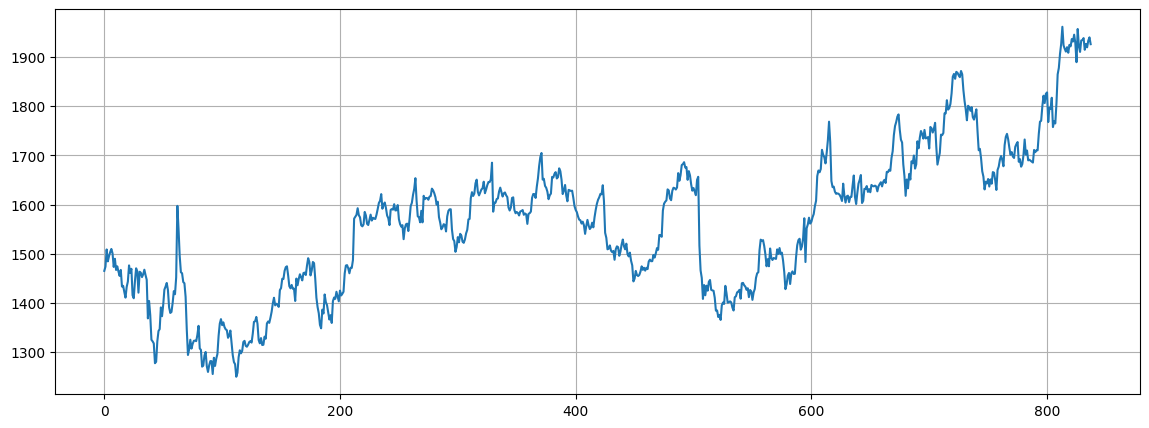

In [353]:
plt.figure(figsize=(14, 5))
plt.plot(df['Close'])

plt.grid('on')
plt.show()

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    838 non-null    datetime64[ns]
 1   Close   838 non-null    float64       
 2   y       837 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 19.8 KB


In [355]:
level = int(len(df)*0.8)

train = df.iloc[:level, 1:]
test = df.iloc[level:, 1:]

train.shape, test.shape

((670, 2), (168, 2))

In [356]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)

train_scaled.shape, train_scaled

((670, 2),
 array([[0.41515397, 0.43168767],
        [0.43168767, 0.49911358],
        [0.49911358, 0.45248006],
        ...,
        [0.80758855, 0.85769068],
        [0.85769068, 0.88409065],
        [0.88409065, 0.94710371]], shape=(670, 2)))

In [357]:
test_scaled = scaler.transform(test[:-1])
test_scaled.shape, test_scaled

((167, 2),
 array([[0.94710371, 0.98294601],
        [0.98294601, 0.9988438 ],
        [0.9988438 , 1.0201372 ],
        [1.0201372 , 1.02851967],
        [1.02851967, 0.96916792],
        [0.96916792, 0.92947162],
        [0.92947162, 0.91819864],
        [0.91819864, 0.83302501],
        [0.83302501, 0.78610244],
        [0.78610244, 0.70931129],
        [0.70931129, 0.77338421],
        [0.77338421, 0.73889082],
        [0.73889082, 0.79525571],
        [0.79525571, 0.77328786],
        [0.77328786, 0.84477974],
        [0.84477974, 0.83707172],
        [0.83707172, 0.8673257 ],
        [0.8673257 , 0.81597102],
        [0.81597102, 0.83273596],
        [0.83273596, 0.92301615],
        [0.92301615, 0.89574903],
        [0.89574903, 0.93669788],
        [0.93669788, 0.9633869 ],
        [0.9633869 , 0.95134312],
        [0.95134312, 0.93361468],
        [0.93361468, 0.96762632],
        [0.96762632, 0.93438548],
        [0.93438548, 0.93650518],
        [0.93650518, 0.93958839],
   

In [358]:
X_train = []
y_train = []

for i in range(len(train_scaled)-50+1):
    X_batch = train_scaled[i:i+50, 0]
    y_batch = train_scaled[i+49, 1]
    X_train.append(torch.tensor(X_batch, dtype=torch.float32).unsqueeze(1))
    y_train.append(torch.tensor(y_batch, dtype=torch.float32))

X_train, y_train

([tensor([[0.4152],
          [0.4317],
          [0.4991],
          [0.4525],
          [0.4726],
          [0.4885],
          [0.5011],
          [0.4839],
          [0.4307],
          [0.4625],
          [0.4186],
          [0.4330],
          [0.4129],
          [0.3954],
          [0.4188],
          [0.3538],
          [0.3564],
          [0.3321],
          [0.3104],
          [0.3521],
          [0.3731],
          [0.4366],
          [0.4072],
          [0.4232],
          [0.3195],
          [0.3078],
          [0.3742],
          [0.4253],
          [0.4137],
          [0.3298],
          [0.4117],
          [0.4079],
          [0.3907],
          [0.4016],
          [0.4197],
          [0.3985],
          [0.3803],
          [0.2289],
          [0.2971],
          [0.2416],
          [0.1450],
          [0.1390],
          [0.1306],
          [0.0531],
          [0.0587],
          [0.1392],
          [0.1793],
          [0.1869],
          [0.2719],
          [0.2374]])

In [359]:
X_test = []
y_test = []

for i in range(len(test_scaled)-50+1):
    X_batch = test_scaled[i:i+50, 0]
    y_batch = test_scaled[i+49, 1]
    X_test.append(torch.tensor(X_batch, dtype=torch.float32).unsqueeze(1))
    y_test.append(torch.tensor(y_batch, dtype=torch.float32))

X_test, y_test

([tensor([[0.9471],
          [0.9829],
          [0.9988],
          [1.0201],
          [1.0285],
          [0.9692],
          [0.9295],
          [0.9182],
          [0.8330],
          [0.7861],
          [0.7093],
          [0.7734],
          [0.7389],
          [0.7953],
          [0.7733],
          [0.8448],
          [0.8371],
          [0.8673],
          [0.8160],
          [0.8327],
          [0.9230],
          [0.8957],
          [0.9367],
          [0.9634],
          [0.9513],
          [0.9336],
          [0.9676],
          [0.9344],
          [0.9365],
          [0.9396],
          [0.8949],
          [0.9792],
          [0.9742],
          [0.9574],
          [0.9726],
          [0.9955],
          [0.9028],
          [0.8318],
          [0.8537],
          [0.8775],
          [0.9491],
          [0.9471],
          [0.9556],
          [1.0327],
          [1.0326],
          [1.0841],
          [1.0472],
          [1.0528],
          [1.0695],
          [1.1111]])

In [360]:
trainable = []

for i in range(len(X_train)):
    trainable.append((X_train[i], y_train[i]))

trainable

[(tensor([[0.4152],
          [0.4317],
          [0.4991],
          [0.4525],
          [0.4726],
          [0.4885],
          [0.5011],
          [0.4839],
          [0.4307],
          [0.4625],
          [0.4186],
          [0.4330],
          [0.4129],
          [0.3954],
          [0.4188],
          [0.3538],
          [0.3564],
          [0.3321],
          [0.3104],
          [0.3521],
          [0.3731],
          [0.4366],
          [0.4072],
          [0.4232],
          [0.3195],
          [0.3078],
          [0.3742],
          [0.4253],
          [0.4137],
          [0.3298],
          [0.4117],
          [0.4079],
          [0.3907],
          [0.4016],
          [0.4197],
          [0.3985],
          [0.3803],
          [0.2289],
          [0.2971],
          [0.2416],
          [0.1450],
          [0.1390],
          [0.1306],
          [0.0531],
          [0.0587],
          [0.1392],
          [0.1793],
          [0.1869],
          [0.2719],
          [0.2374]])

In [361]:
trainable_test = []

for i in range(len(X_test)):
    trainable_test.append((X_test[i], y_test[i]))

trainable_test

[(tensor([[0.9471],
          [0.9829],
          [0.9988],
          [1.0201],
          [1.0285],
          [0.9692],
          [0.9295],
          [0.9182],
          [0.8330],
          [0.7861],
          [0.7093],
          [0.7734],
          [0.7389],
          [0.7953],
          [0.7733],
          [0.8448],
          [0.8371],
          [0.8673],
          [0.8160],
          [0.8327],
          [0.9230],
          [0.8957],
          [0.9367],
          [0.9634],
          [0.9513],
          [0.9336],
          [0.9676],
          [0.9344],
          [0.9365],
          [0.9396],
          [0.8949],
          [0.9792],
          [0.9742],
          [0.9574],
          [0.9726],
          [0.9955],
          [0.9028],
          [0.8318],
          [0.8537],
          [0.8775],
          [0.9491],
          [0.9471],
          [0.9556],
          [1.0327],
          [1.0326],
          [1.0841],
          [1.0472],
          [1.0528],
          [1.0695],
          [1.1111]])

In [362]:
from torch.utils.data import Dataset, DataLoader

In [363]:
class StockDataset(Dataset):
    def __init__(self, trainable):
        super().__init__()
        self.data = trainable

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [364]:
train_dataset = StockDataset(trainable=trainable)
test_dataset = StockDataset(trainable=trainable_test)
train_dataset, test_dataset

(<__main__.StockDataset at 0x30295b4d0>,
 <__main__.StockDataset at 0x310d5cb90>)

In [365]:
len(train_dataset), train_dataset[0]

(621,
 (tensor([[0.4152],
          [0.4317],
          [0.4991],
          [0.4525],
          [0.4726],
          [0.4885],
          [0.5011],
          [0.4839],
          [0.4307],
          [0.4625],
          [0.4186],
          [0.4330],
          [0.4129],
          [0.3954],
          [0.4188],
          [0.3538],
          [0.3564],
          [0.3321],
          [0.3104],
          [0.3521],
          [0.3731],
          [0.4366],
          [0.4072],
          [0.4232],
          [0.3195],
          [0.3078],
          [0.3742],
          [0.4253],
          [0.4137],
          [0.3298],
          [0.4117],
          [0.4079],
          [0.3907],
          [0.4016],
          [0.4197],
          [0.3985],
          [0.3803],
          [0.2289],
          [0.2971],
          [0.2416],
          [0.1450],
          [0.1390],
          [0.1306],
          [0.0531],
          [0.0587],
          [0.1392],
          [0.1793],
          [0.1869],
          [0.2719],
          [0.2

In [366]:
len(test_dataset), test_dataset[0]

(118,
 (tensor([[0.9471],
          [0.9829],
          [0.9988],
          [1.0201],
          [1.0285],
          [0.9692],
          [0.9295],
          [0.9182],
          [0.8330],
          [0.7861],
          [0.7093],
          [0.7734],
          [0.7389],
          [0.7953],
          [0.7733],
          [0.8448],
          [0.8371],
          [0.8673],
          [0.8160],
          [0.8327],
          [0.9230],
          [0.8957],
          [0.9367],
          [0.9634],
          [0.9513],
          [0.9336],
          [0.9676],
          [0.9344],
          [0.9365],
          [0.9396],
          [0.8949],
          [0.9792],
          [0.9742],
          [0.9574],
          [0.9726],
          [0.9955],
          [0.9028],
          [0.8318],
          [0.8537],
          [0.8775],
          [0.9491],
          [0.9471],
          [0.9556],
          [1.0327],
          [1.0326],
          [1.0841],
          [1.0472],
          [1.0528],
          [1.0695],
          [1.1

In [367]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x310cf0d50>,
 <torch.utils.data.dataloader.DataLoader at 0x310cf1050>)

In [368]:
for batch in train_dataloader:
    print(batch)
    break

[tensor([[[0.7719],
         [0.7839],
         [0.5147],
         ...,
         [0.3016],
         [0.3306],
         [0.3443]],

        [[0.3053],
         [0.3595],
         [0.3196],
         ...,
         [0.4097],
         [0.4958],
         [0.5376]],

        [[0.6356],
         [0.6123],
         [0.6233],
         ...,
         [0.7009],
         [0.7005],
         [0.6940]],

        ...,

        [[0.1340],
         [0.1691],
         [0.2152],
         ...,
         [0.4357],
         [0.4649],
         [0.4499]],

        [[0.5714],
         [0.6157],
         [0.6691],
         ...,
         [0.5250],
         [0.5378],
         [0.5618]],

        [[0.1111],
         [0.1054],
         [0.0398],
         ...,
         [0.2176],
         [0.2347],
         [0.2077]]]), tensor([0.3873, 0.5320, 0.7063, 0.6214, 0.2479, 0.4058, 0.7162, 0.0577, 0.2823,
        0.3838, 0.5949, 0.5858, 0.4029, 0.3117, 0.3898, 0.5984, 0.5603, 0.1844,
        0.6574, 0.1899, 0.1605, 0.5217, 0.61

In [369]:
batch[0].shape, batch[1].shape

(torch.Size([32, 50, 1]), torch.Size([32]))

In [370]:
for batch in test_dataloader:
    print(batch)
    break

[tensor([[[0.9471],
         [0.9829],
         [0.9988],
         [1.0201],
         [1.0285],
         [0.9692],
         [0.9295],
         [0.9182],
         [0.8330],
         [0.7861],
         [0.7093],
         [0.7734],
         [0.7389],
         [0.7953],
         [0.7733],
         [0.8448],
         [0.8371],
         [0.8673],
         [0.8160],
         [0.8327],
         [0.9230],
         [0.8957],
         [0.9367],
         [0.9634],
         [0.9513],
         [0.9336],
         [0.9676],
         [0.9344],
         [0.9365],
         [0.9396],
         [0.8949],
         [0.9792],
         [0.9742],
         [0.9574],
         [0.9726],
         [0.9955],
         [0.9028],
         [0.8318],
         [0.8537],
         [0.8775],
         [0.9491],
         [0.9471],
         [0.9556],
         [1.0327],
         [1.0326],
         [1.0841],
         [1.0472],
         [1.0528],
         [1.0695],
         [1.1111]],

        [[0.9829],
         [0.9988],
         

In [371]:
batch[0].shape, batch[1].shape

(torch.Size([16, 50, 1]), torch.Size([16]))

In [372]:
len(train_dataloader), len(test_dataloader)

(20, 8)

Now our dataset is ready for RNN/LSTM models

In [373]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

device

'mps'

In [374]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, nonlinearity, dropout, bidirectional):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, nonlinearity=nonlinearity, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, h = self.rnn(x) # output: (batch, seq_len, hidden_size)
        output = self.linear(output[:, -1, :]) # passing only last value of hidden layer for each batch (h_n value), we can also pass mean etch for all sequences too
        return output
    
simpleRNN = SimpleRNN(input_size=1, output_size=1, hidden_size=64, num_layers=1, nonlinearity="tanh", dropout=0, bidirectional=False)
simpleRNN.to(device=device)

simpleRNN, next(simpleRNN.parameters()).device, sum(torch.numel(i) for i in simpleRNN.parameters() if i.requires_grad), simpleRNN.state_dict()

(SimpleRNN(
   (rnn): RNN(1, 64, batch_first=True)
   (linear): Linear(in_features=64, out_features=1, bias=True)
 ),
 device(type='mps', index=0),
 4353,
 OrderedDict([('rnn.weight_ih_l0',
               tensor([[-0.0910],
                       [-0.0794],
                       [-0.0998],
                       [ 0.0804],
                       [-0.0517],
                       [-0.0635],
                       [-0.0828],
                       [-0.0361],
                       [-0.0142],
                       [ 0.0618],
                       [ 0.0394],
                       [-0.0285],
                       [-0.0149],
                       [-0.0813],
                       [ 0.0176],
                       [-0.0193],
                       [ 0.0779],
                       [ 0.0278],
                       [ 0.0286],
                       [ 0.0456],
                       [-0.0831],
                       [-0.0817],
                       [ 0.0299],
                       [ 0.0

In [375]:
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=simpleRNN.parameters(), lr=3e-3)
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_test_loss = 0

    simpleRNN.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = simpleRNN(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)

    simpleRNN.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device=device)
            y = y.to(device=device)

            preds_test = simpleRNN(X)
            loss_test = loss_fn(preds_test, y)
            epoch_test_loss += loss_test.item()
        epoch_test_loss /= len(test_dataloader)
        test_loss.append(epoch_test_loss)

    if epoch%10==0:
        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Test Loss: {epoch_test_loss}")


Epoch: 0, Train Loss: 0.1168279193341732, Test Loss: 0.16227748012170196
Epoch: 10, Train Loss: 0.04803939573466778, Test Loss: 0.3424399308860302
Epoch: 20, Train Loss: 0.047238392382860185, Test Loss: 0.3116273060441017
Epoch: 30, Train Loss: 0.04628253802657127, Test Loss: 0.27115095034241676
Epoch: 40, Train Loss: 0.04663279680535197, Test Loss: 0.2902810452505946
Epoch: 50, Train Loss: 0.04685000535100699, Test Loss: 0.2972762659192085
Epoch: 60, Train Loss: 0.04841442350298166, Test Loss: 0.2435563551262021
Epoch: 70, Train Loss: 0.04842431750148535, Test Loss: 0.2881740005686879
Epoch: 80, Train Loss: 0.046895064227283, Test Loss: 0.2482437388971448
Epoch: 90, Train Loss: 0.15955753549933432, Test Loss: 0.7985013648867607


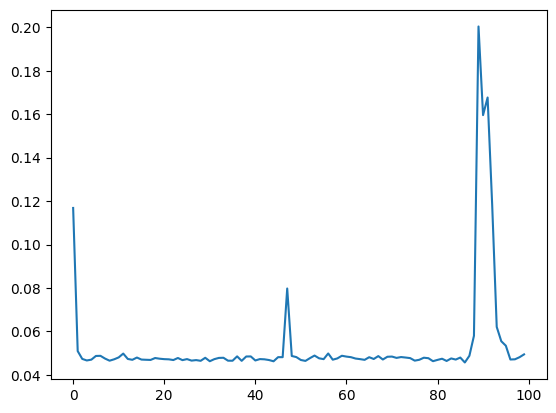

In [376]:
plt.plot(train_loss)

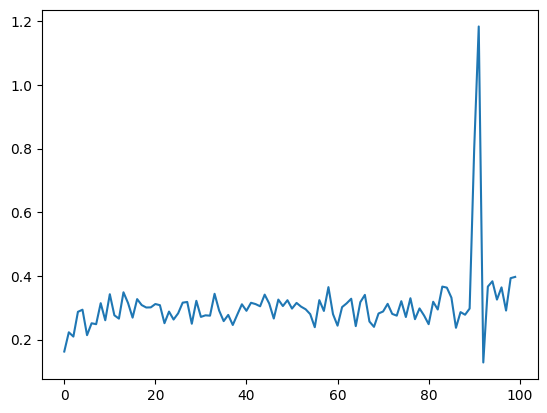

In [377]:
plt.plot(test_loss)

In [378]:
outputs = []
truths = []

simpleRNN.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        preds = simpleRNN(X.to(device))
        outputs += preds.cpu()
        truths += y.cpu()

outputs = [i.item() for i in outputs]
outputs, truths

([0.45400378108024597,
  0.4547831118106842,
  0.45487675070762634,
  0.4546546936035156,
  0.4550185799598694,
  0.45494458079338074,
  0.45483526587486267,
  0.45475319027900696,
  0.45505526661872864,
  0.4548744261264801,
  0.4541301429271698,
  0.45364144444465637,
  0.4532456696033478,
  0.4527280926704407,
  0.45345190167427063,
  0.4533228874206543,
  0.453164666891098,
  0.45335760712623596,
  0.45285627245903015,
  0.4527682363986969,
  0.45300212502479553,
  0.45324432849884033,
  0.4521704614162445,
  0.4513164460659027,
  0.4514138698577881,
  0.4509258568286896,
  0.4503103494644165,
  0.45006731152534485,
  0.4494410455226898,
  0.44984006881713867,
  0.4497232139110565,
  0.44994795322418213,
  0.44956958293914795,
  0.4499398171901703,
  0.44970402121543884,
  0.4502886235713959,
  0.45023083686828613,
  0.44987937808036804,
  0.4494173228740692,
  0.4504113495349884,
  0.45051753520965576,
  0.45086669921875,
  0.45103177428245544,
  0.4508436620235443,
  0.4505480825

In [379]:
otp = pd.DataFrame(outputs)
otp['nn'] = truths

otp.columns = ['outputs', 'actual']
otp

,outputs,actual
0,0.454004,tensor(1.1762)
1,0.454783,tensor(1.1871)
2,0.454877,tensor(1.1680)
3,0.454655,tensor(1.1953)
4,0.455019,tensor(1.1916)
...,...,...
113,0.456010,tensor(1.3048)
114,0.456340,tensor(1.2915)
115,0.456138,tensor(1.3179)
116,0.456482,tensor(1.3306)


[]

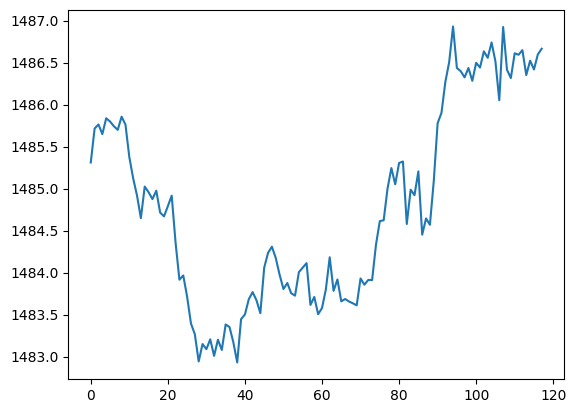

In [380]:
plt.plot(scaler.inverse_transform(otp)[:, 0])

plt.plot()

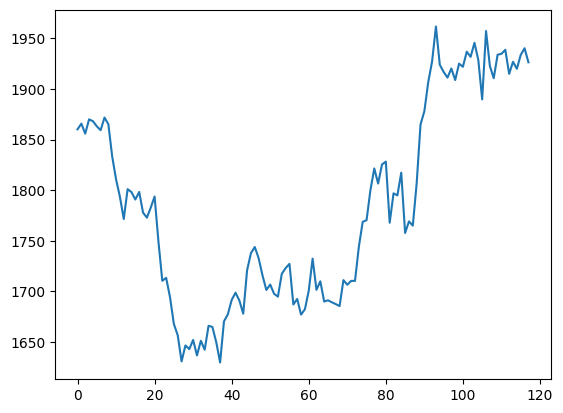

In [381]:
plt.plot(scaler.inverse_transform(otp)[:, 1])


Probably we need a better model

## Stacked RNN

In [400]:
class StackedRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, nonlinearity, dropout, bidirectional):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, nonlinearity=nonlinearity, dropout=dropout, bidirectional=bidirectional, batch_first=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, h = self.rnn(x) # output: (batch, seq_len, hidden_size)
        output = self.linear(output[:, -1, :]) # passing only last value of hidden layer for each batch (h_n value), we can also pass mean etch for all sequences too
        return output
    
stackedRNN = StackedRNN(input_size=1, output_size=1, hidden_size=64, num_layers=3, nonlinearity="tanh", dropout=0, bidirectional=False)
stackedRNN.to(device=device)

stackedRNN, next(stackedRNN.parameters()).device, sum(torch.numel(i) for i in stackedRNN.parameters() if i.requires_grad), stackedRNN.state_dict()

(StackedRNN(
   (rnn): RNN(1, 64, num_layers=3, batch_first=True)
   (linear): Linear(in_features=64, out_features=1, bias=True)
 ),
 device(type='mps', index=0),
 20993,
 OrderedDict([('rnn.weight_ih_l0',
               tensor([[ 0.0266],
                       [-0.0527],
                       [-0.1015],
                       [ 0.1054],
                       [ 0.0348],
                       [ 0.0074],
                       [-0.1224],
                       [ 0.0530],
                       [ 0.0595],
                       [-0.0517],
                       [-0.1169],
                       [ 0.0487],
                       [-0.1054],
                       [-0.1214],
                       [ 0.1186],
                       [ 0.0757],
                       [-0.1204],
                       [ 0.1045],
                       [ 0.1250],
                       [ 0.1200],
                       [-0.0941],
                       [ 0.1007],
                       [ 0.0718],
            

In [401]:
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=stackedRNN.parameters(), lr=3e-3)
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_test_loss = 0

    stackedRNN.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = stackedRNN(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)

    stackedRNN.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device=device)
            y = y.to(device=device)

            preds_test = stackedRNN(X)
            loss_test = loss_fn(preds_test, y)
            epoch_test_loss += loss_test.item()
        epoch_test_loss /= len(test_dataloader)
        test_loss.append(epoch_test_loss)

    if epoch%10==0:
        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Test Loss: {epoch_test_loss}")


Epoch: 0, Train Loss: 0.09022333342581987, Test Loss: 0.32160679437220097
Epoch: 10, Train Loss: 0.04783195042982698, Test Loss: 0.28223973605781794
Epoch: 20, Train Loss: 0.047464478947222236, Test Loss: 0.3032027669250965
Epoch: 30, Train Loss: 0.04724260708317161, Test Loss: 0.31467648036777973
Epoch: 40, Train Loss: 0.046602911129593846, Test Loss: 0.3210317026823759
Epoch: 50, Train Loss: 0.04735462320968509, Test Loss: 0.30612543411552906
Epoch: 60, Train Loss: 0.04759845156222582, Test Loss: 0.30773872323334217
Epoch: 70, Train Loss: 0.04767728336155415, Test Loss: 0.3427599994465709
Epoch: 80, Train Loss: 0.04657017029821873, Test Loss: 0.28463695757091045
Epoch: 90, Train Loss: 0.04754276778548956, Test Loss: 0.35963917151093483


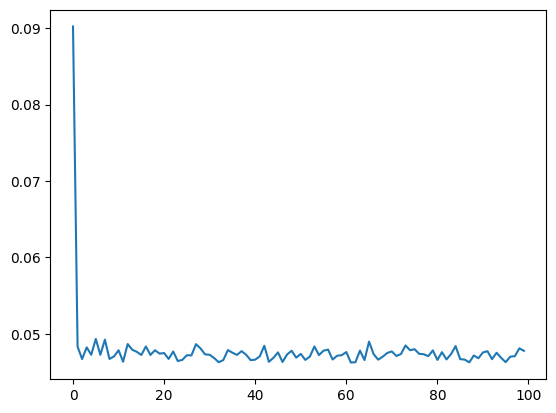

In [402]:
plt.plot(train_loss)

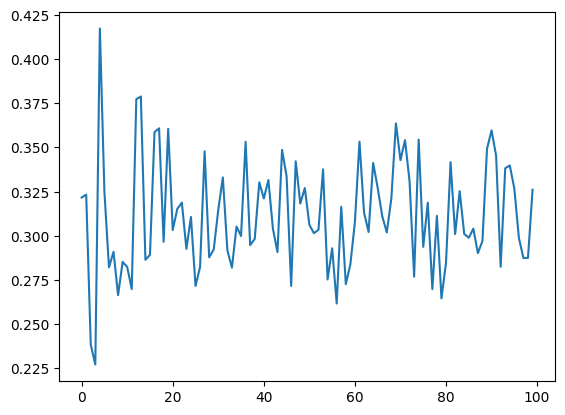

In [403]:
plt.plot(test_loss)

In [404]:
outputs = []
truths = []

stackedRNN.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        preds = stackedRNN(X.to(device))
        outputs += preds.cpu()
        truths += y.cpu()

outputs = [i.item() for i in outputs]
otp = pd.DataFrame(outputs)
otp['nn'] = truths

otp.columns = ['outputs', 'actual']
otp

,outputs,actual
0,0.516136,tensor(1.1762)
1,0.519605,tensor(1.1871)
2,0.516357,tensor(1.1680)
3,0.518628,tensor(1.1953)
4,0.517794,tensor(1.1916)
...,...,...
113,0.517175,tensor(1.3048)
114,0.522461,tensor(1.2915)
115,0.518017,tensor(1.3179)
116,0.521867,tensor(1.3306)


[]

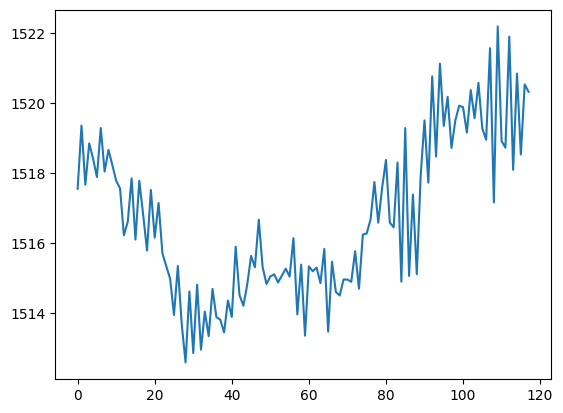

In [405]:
plt.plot(scaler.inverse_transform(otp)[:, 0])

plt.plot()

[]

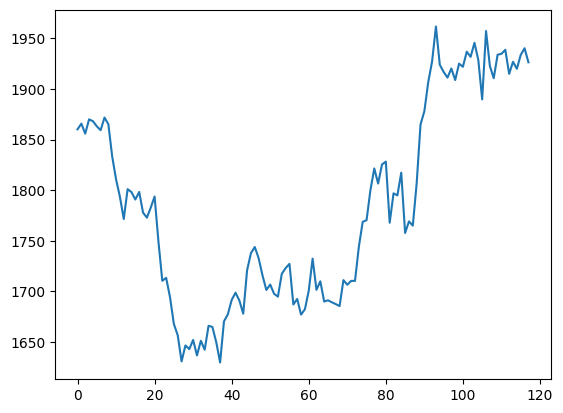

In [406]:
plt.plot(scaler.inverse_transform(otp)[:, 1])

plt.plot()

[]

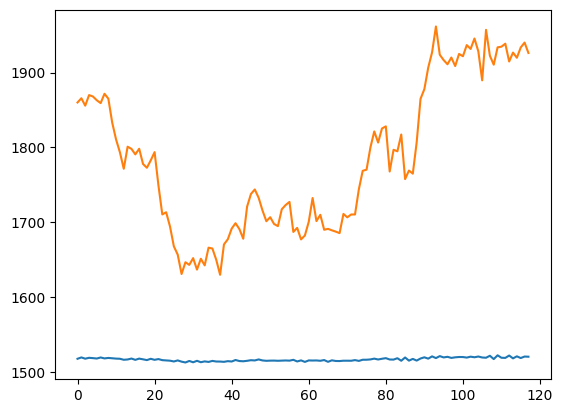

In [407]:
plt.plot(scaler.inverse_transform(otp)[:, 0])
plt.plot(scaler.inverse_transform(otp)[:, 1])

plt.plot()

Building bidirectional stacked RNNs

In [414]:
class BiDirectionalRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.linear = nn.Linear(in_features=hidden_size*2, out_features=output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        output, h = self.rnn(x)
        return self.linear(output[:, -1, :])
    
bidirRNN = BiDirectionalRNN(input_size=1, output_size=1, hidden_size=64, num_layers=3, dropout=0.2)
bidirRNN.to(device=device)

bidirRNN, next(bidirRNN.parameters()).device, sum(torch.numel(i) for i in bidirRNN.parameters() if i.requires_grad), bidirRNN.state_dict()

(BiDirectionalRNN(
   (rnn): RNN(1, 64, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
   (linear): Linear(in_features=128, out_features=1, bias=True)
 ),
 device(type='mps', index=0),
 58369,
 OrderedDict([('rnn.weight_ih_l0',
               tensor([[-0.0302],
                       [-0.0505],
                       [ 0.0827],
                       [-0.0104],
                       [ 0.0978],
                       [-0.0709],
                       [-0.0512],
                       [-0.0328],
                       [-0.0423],
                       [-0.0183],
                       [-0.0703],
                       [-0.0711],
                       [ 0.0325],
                       [ 0.0973],
                       [ 0.0508],
                       [-0.0385],
                       [ 0.0081],
                       [-0.0036],
                       [ 0.1123],
                       [-0.0834],
                       [ 0.0730],
                       [-0.0126],
      

In [415]:
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=bidirRNN.parameters(), lr=3e-3)
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    epoch_test_loss = 0

    bidirRNN.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        preds = bidirRNN(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_dataloader)
    train_loss.append(epoch_loss)

    bidirRNN.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X = X.to(device=device)
            y = y.to(device=device)

            preds_test = bidirRNN(X)
            loss_test = loss_fn(preds_test, y)
            epoch_test_loss += loss_test.item()
        epoch_test_loss /= len(test_dataloader)
        test_loss.append(epoch_test_loss)

    if epoch%10==0:
        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Test Loss: {epoch_test_loss}")


Epoch: 0, Train Loss: 0.07910326160490513, Test Loss: 0.31759721133857965
Epoch: 10, Train Loss: 0.047109179012477395, Test Loss: 0.3080948293209076
Epoch: 20, Train Loss: 0.04698648508638144, Test Loss: 0.30227355007082224
Epoch: 30, Train Loss: 0.04670276567339897, Test Loss: 0.32064213044941425
Epoch: 40, Train Loss: 0.047009289637207984, Test Loss: 0.3157074600458145
Epoch: 50, Train Loss: 0.04731856621801853, Test Loss: 0.31658370420336723
Epoch: 60, Train Loss: 0.04606800051406026, Test Loss: 0.3593498654663563
Epoch: 70, Train Loss: 0.046689005196094514, Test Loss: 0.29805656895041466
Epoch: 80, Train Loss: 0.047179751098155975, Test Loss: 0.2932500233873725
Epoch: 90, Train Loss: 0.04690042920410633, Test Loss: 0.2818930493667722


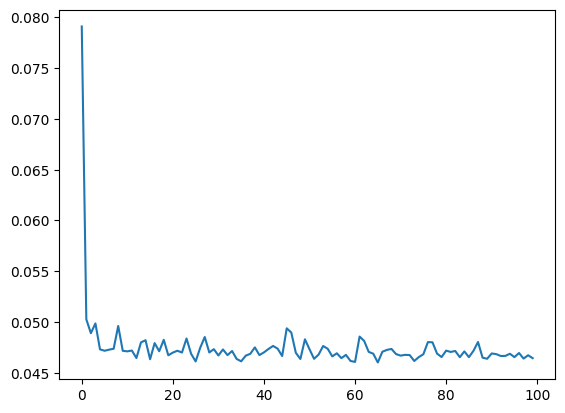

In [416]:
plt.plot(train_loss)

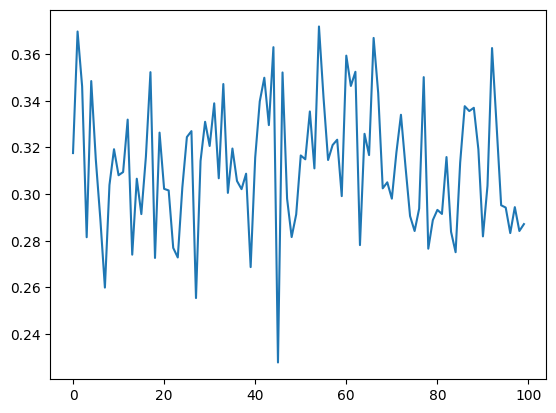

In [417]:
plt.plot(test_loss)

In [418]:
outputs = []
truths = []

stackedRNN.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        preds = stackedRNN(X.to(device))
        outputs += preds.cpu()
        truths += y.cpu()

outputs = [i.item() for i in outputs]
otp = pd.DataFrame(outputs)
otp['nn'] = truths

otp.columns = ['outputs', 'actual']
otp

,outputs,actual
0,0.516136,tensor(1.1762)
1,0.519605,tensor(1.1871)
2,0.516357,tensor(1.1680)
3,0.518628,tensor(1.1953)
4,0.517794,tensor(1.1916)
...,...,...
113,0.517175,tensor(1.3048)
114,0.522461,tensor(1.2915)
115,0.518017,tensor(1.3179)
116,0.521867,tensor(1.3306)


[]

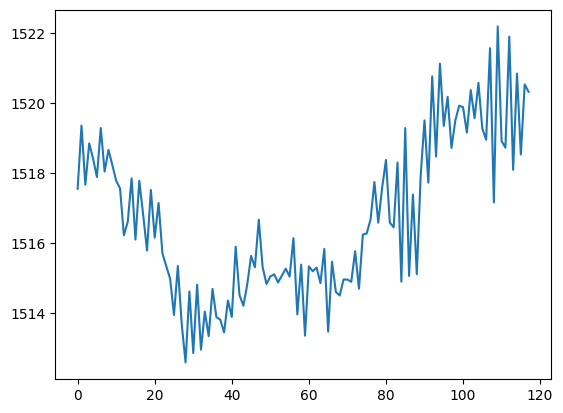

In [419]:
plt.plot(scaler.inverse_transform(otp)[:, 0])

plt.plot()

[]

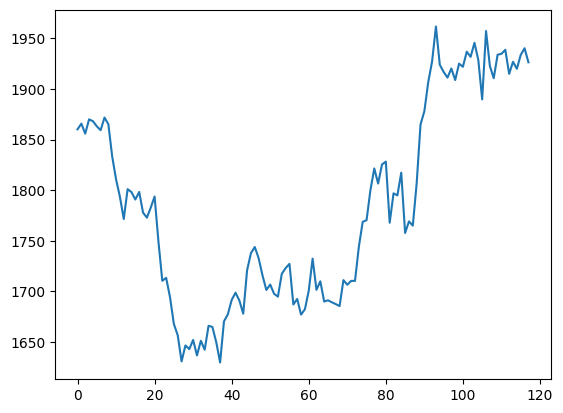

In [420]:
plt.plot(scaler.inverse_transform(otp)[:, 1])

plt.plot()

Looks like we aren't making that good model. Let's try a custom model with
- Dropout layers
- Self attention layers
- Batch normal layers
- Residual layers

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self):
        super().__init__()
        pass

    def forward(self, x):
        pass

class CustomModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, dropout_layers=None, attention_layers=None, batchnorm_layers=None, residual_layers=None):
        super().__init__()
        self.output_size = output_size

        self.rnn_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        self.attentions = nn.ModuleList()
        self.batchnorms = nn.ModuleList()

        for i in range(num_layers):
            size = input_size if i==0 else hidden_size*2
            self.rnn_layers.append(
                nn.RNN(input_size=size, hidden_size=hidden_size, num_layers=1, batch_first=True, bidirectional=True)
            )
            
            if dropout_layers and i in dropout_layers:
                self.dropouts[str(i)] = nn.Dropout(p=0.3)
            
            if batchnorm_layers and i in batchnorm_layers:
                self.batchnorms[str(i)] = nn.BatchNorm1d(num_features=hidden_size*2)

            if attention_layers and i in attention_layers:
                self.attentions[str(i)] = SelfAttention(hidden_size*2)

        self.linear = nn.Linear(in_features=hidden_size*2, out_features=output_size)
        self.residual_layers = residual_layers if residual_layers else []

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i, rnn in enumerate(self.rnn_layers):
            output, hn = rnn(x)
            if str(i) in self.attentions:
                output = self.attentions[str(i)](output)

            if str(i) in self.batchnorms:
                output = self.batchnorms[str(i)](output)

            if str(i) in self.dropouts:
                output = self.dropouts[str(i)](output)